In [52]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
19,12July_gpt2_10dim_12layer_256_RL,linear_regression,Transformer,,-1,-1,10,12,8,12July_gpt2_10dim_12layer_256_RL
21,12July_mlp_10dim_10layer_1024_RL,linear_regression,12July_mlp_10dim_10layer_1024_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_1024_RL
24,12July_mlp_10dim_10layer_512_RL,linear_regression,12July_mlp_10dim_10layer_512_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_512_RL
20,12July_mlp_10dim_22layer_1024_RL,linear_regression,12July_mlp_10dim_22layer_1024_RL,,-1,-1,10,22,8,12July_mlp_10dim_22layer_1024_RL
22,12July_mlp_10dim_5layer_1024_RL,linear_regression,12July_mlp_10dim_5layer_1024_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_1024_RL
23,12July_mlp_10dim_5layer_512_RL,linear_regression,12July_mlp_10dim_5layer_512_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_512_RL
26,24July_lstm_10dim_1layer_256_RL,linear_regression,24July_lstm_10dim_1layer_256_RL,,-1,-1,10,1,8,24July_lstm_10dim_1layer_256_RL
28,24July_lstm_10dim_5layer_256_RL,linear_regression,24July_lstm_10dim_5layer_256_RL,,-1,-1,10,5,8,24July_lstm_10dim_5layer_256_RL
25,24July_lstm_20dim_1layer_256_RL,linear_regression,24July_lstm_20dim_1layer_256_RL,,-1,-1,20,1,8,24July_lstm_20dim_1layer_256_RL
29,24July_lstm_20dim_5layer_256_RL,linear_regression,24July_lstm_20dim_5layer_256_RL,,-1,-1,20,5,8,24July_lstm_20dim_5layer_256_RL


In [54]:
"""
in our case, use linear regression
"""

task = "linear_regression" 
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

"""
Replace run_id
"""
run_id = "24July_lstm_20dim_1layer_256_RL"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

24July_lstm_20dim_1layer_256_RL 24July_lstm_20dim_1layer_256_RL


100%|██████████| 15/15 [00:00<00:00, 211122.68it/s]

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.031069278717041, 0.8842317581176757, 0.906977653503418, 0.9338140487670898, 0.8315250396728515, 0.8153178215026855, 0.7613882541656494, 0.680099630355835, 0.6825024604797363, 0.6254451751708985, 0.5836148262023926, 0.5723346710205078, 0.5367664337158203, 0.507769775390625, 0.49143228530883787, 0.4597890377044678, 0.43524789810180664, 0.3928207874298096, 0.40502176284790037, 0.35853760242462157, 0.3569322109222412, 0.32642645835876466, 0.3355370283126831, 0.27177963256835935, 0.3116481781005859, 0.26567931175231935, 0.26353189945220945, 0.2615081787109375, 0.22285962104797363, 0.2257091999053955, 0.2057953357696533, 0.19252321720123292, 0.1819742202758789, 0.1801661252975464, 0.17681436538696288, 0.1613501191139221, 0.1524754524230957, 0.1399247407913208, 0.1362179398536682, 0.1252471089363098, 0.11552318334579467], 'std': [1.5155138969421387, 1.2880167007446288, 1.42555580139

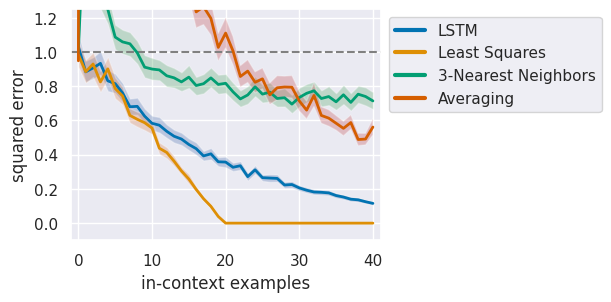

In [55]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0253377914428712, 0.8991217613220215, 0.8466013908386231, 0.7117631435394287, 0.6578671932220459, 0.5408827781677246, 0.5459034442901611, 0.5165220260620117, 0.4163553237915039, 0.35266594886779784, 0.32186806201934814, 0.3117868423461914, 0.2574460506439209, 0.22652719020843506, 0.2237006187438965, 0.19853063821792602, 0.1704823136329651, 0.1475841760635376, 0.1363925337791443, 0.128001070022583, 0.12233422994613648, 0.09396459460258484, 0.08372761011123657, 0.08088642358779907, 0.07601222395896912, 0.06404843926429749, 0.05879253149032593, 0.05366974472999573, 0.04828445911407471, 0.040208238363265994, 0.03431522250175476, 0.033871439099311826, 0.03191013038158417, 0.03055891990661621, 0.025131115317344667, 0.024757328629493713, 0.0228566437959671, 0.021697625517845154, 0.020010451972484588, 0.019783321022987365, 0.016432689130306245], 'std': [1.6026142120361329, 1.48043241

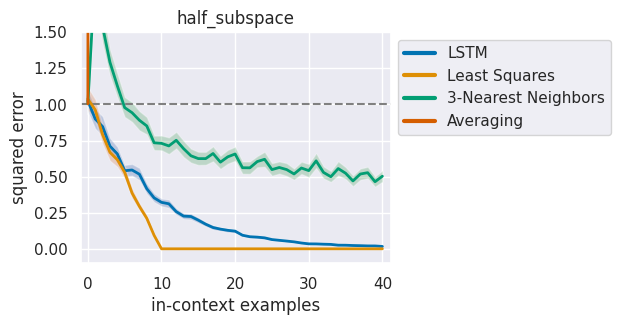

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.997124195098877, 0.9169649124145508, 0.8358218193054199, 0.8613033294677734, 0.8291098594665527, 0.812864875793457, 0.8188025474548339, 0.7334850311279297, 0.725228214263916, 0.646108865737915, 0.612425422668457, 0.5854748725891114, 0.6029548168182373, 0.5641943454742432, 0.5106162071228028, 0.5156816482543946, 0.5003424644470215, 0.48172292709350584, 0.4649998188018799, 0.4593208312988281, 0.41342554092407224, 0.40705361366271975, 0.3801367998123169, 0.38977324962615967, 0.3402251720428467, 0.34949355125427245, 0.32701849937438965, 0.2926147937774658, 0.3161136627197266, 0.3032684326171875, 0.2700488567352295, 0.29826366901397705, 0.28642241954803466, 0.2647791624069214, 0.2625412464141846, 0.25257532596588134, 0.2621422290802002, 0.23677732944488525, 0.25067458152770994, 0.2211606502532959, 0.21847045421600342], 'std': [1.4420413017272948, 1.3411717414855957, 1.194390678405

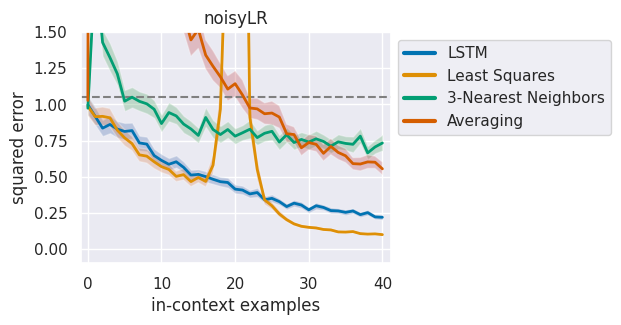

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9821270942687989, 0.9574490547180176, 1.0189433097839355, 1.0300138473510743, 1.0013236999511719, 1.079325008392334, 1.0768718719482422, 1.029580020904541, 0.9555951118469238, 1.0585295677185058, 0.9852197647094727, 1.0053743362426757, 1.036488151550293, 0.9388295173645019, 0.9903375625610351, 0.9302194595336915, 0.9924798965454101, 0.9695773124694824, 0.9975687026977539, 0.9669976234436035, 0.0008326566778123379, 0.000806855782866478, 0.0008124842308461667, 0.0008897749707102775, 0.0008147872053086757, 0.0007865980267524719, 0.000755339115858078, 0.0007901864126324653, 0.0007475198712199926, 0.0007519627921283245, 0.0007295574061572552, 0.0006607519928365946, 0.0006755095906555653, 0.0006293333135545254, 0.0006696718744933605, 0.0006349205970764161, 0.0006609469652175904, 0.0006379169877618551, 0.000693218782544136, 0.0006528377532958984, 0.0006366179324686528], 'std': [1.64

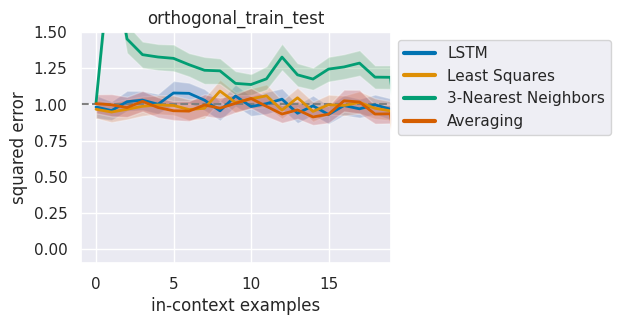

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0852529525756835, 0.020463311672210695, 0.028092962503433228, 0.04145302176475525, 0.0516850471496582, 0.05289667844772339, 0.059514909982681274, 0.0833336055278778, 0.09213153719902038, 0.09638921022415162, 0.10655759572982788, 0.09867817163467407, 0.11609539985656739, 0.1031762957572937, 0.10084090232849122, 0.10349665880203247, 0.11559439897537231, 0.10673301219940186, 0.11306442022323608, 0.10836457014083863, 0.10978715419769287, 0.11860287189483643, 0.11285223960876464, 0.10316874980926513, 0.10830061435699463, 0.09602376222610473, 0.10117601156234741, 0.10443265438079834, 0.08564546704292297, 0.09419735670089721, 0.088738614320755, 0.09606627225875855, 0.08529620170593262, 0.08667351007461548, 0.08073692321777344, 0.07446457147598266, 0.07189275026321411, 0.06544900536537171, 0.07290955781936645, 0.06602746248245239, 0.0691977858543396], 'std': [1.6695941925048827, 0.04

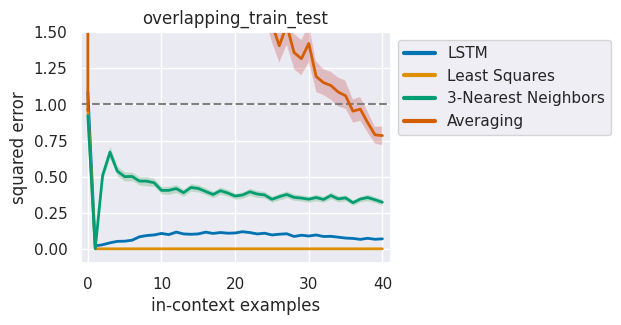

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0444023132324218, 0.9327070236206054, 0.8911514282226562, 0.9084666252136231, 0.8846975326538086, 0.8921606063842773, 0.7714064121246338, 0.781132984161377, 0.7740624904632568, 0.7175099372863769, 0.7742833137512207, 0.7103068351745605, 0.7198162078857422, 0.739761209487915, 0.6988407135009765, 0.6685353755950928, 0.7097447872161865, 0.665093469619751, 0.7784807682037354, 0.744095754623413, 0.7247576236724853, 0.7498057365417481, 0.7349255561828614, 0.670791482925415, 0.7710520267486572, 0.7364570617675781, 0.7624226570129394, 0.7801724910736084, 0.742941951751709, 0.856009578704834, 0.8297778129577636, 0.9004841804504394, 0.8610563278198242, 0.766939640045166, 0.8786813735961914, 0.8798870086669922, 0.8539822578430176, 0.9747470855712891, 0.9448106765747071, 0.9768823623657227, 0.9567243576049804], 'std': [1.566963291168213, 1.4538602828979492, 1.3364017486572266, 1.42128314

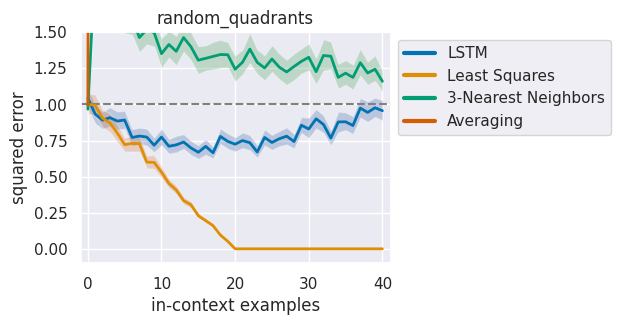

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.10654990673065186, 0.11084266901016235, 0.1033287763595581, 0.10071935653686523, 0.09130107164382935, 0.09510875940322876, 0.0835818111896515, 0.08649646639823913, 0.07875783443450927, 0.08106799125671386, 0.0775353729724884, 0.08343261480331421, 0.07508885860443115, 0.07354736924171448, 0.06983809471130371, 0.06275798082351684, 0.06369971632957458, 0.05669277906417847, 0.06219255328178406, 0.05934187173843384, 0.05267034769058228, 0.05016714334487915, 0.054322725534439086, 0.05234402418136597, 0.04929966330528259, 0.04961145520210266, 0.044063147902488706, 0.04744831621646881, 0.04436202645301819, 0.044500294327735904, 0.043512001633644104, 0.04513267576694489, 0.04224313795566559, 0.04104837775230408, 0.04128347337245941, 0.04134667813777924, 0.04056834578514099, 0.041891878843307494, 0.03621439933776856, 0.03837686479091644, 0.03802758157253265], 'std': [0.1542178034782409

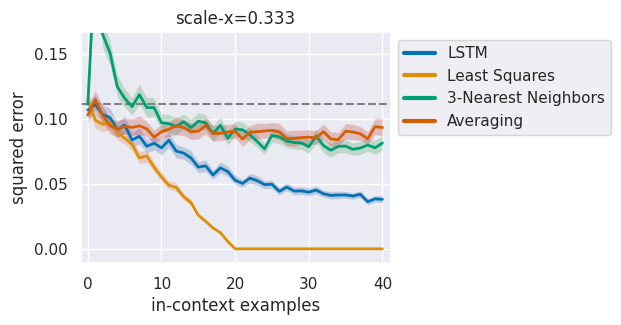

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.2331019163131714, 0.23517837524414062, 0.23285043239593506, 0.2179262161254883, 0.21339361667633056, 0.20067906379699707, 0.21432008743286132, 0.17104657888412475, 0.1823408842086792, 0.15871524810791016, 0.16332652568817138, 0.16444793939590455, 0.1393948793411255, 0.1268492102622986, 0.1350144624710083, 0.1202589750289917, 0.12224915027618408, 0.1086773157119751, 0.11782245635986328, 0.10036718845367432, 0.10230598449707032, 0.10127344131469726, 0.09313948750495911, 0.09259503483772277, 0.08343192338943481, 0.07885116338729858, 0.07832756638526917, 0.07451313138008117, 0.07141653895378113, 0.07024221420288086, 0.07412830591201783, 0.06527029275894165, 0.06092572212219238, 0.06225654482841492, 0.05716091990470886, 0.05263434648513794, 0.05259122252464295, 0.05292827486991882, 0.05050063133239746, 0.04765501916408539, 0.042700132727622984], 'std': [0.3485184907913208, 0.33041

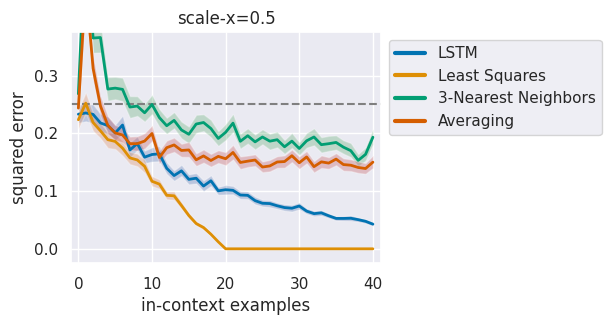

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [3.8856170654296873, 3.9973236083984376, 3.4481639862060547, 3.618517303466797, 3.3181034088134767, 3.090851974487305, 2.9030200958251955, 3.1316659927368162, 2.8443988800048827, 2.593772315979004, 2.4314752578735352, 2.383443069458008, 2.346993064880371, 2.1648956298828126, 2.2213762283325194, 2.1917028427124023, 2.0174276351928713, 1.8336620330810547, 1.8728076934814453, 1.8580175399780274, 1.5280927658081054, 1.5651113510131835, 1.5421236991882323, 1.595747947692871, 1.3004712104797362, 1.3682568550109864, 1.3464340209960937, 1.34417781829834, 1.2174043655395508, 1.248469352722168, 1.2264935493469238, 1.0646355628967286, 1.088485050201416, 1.0153768539428711, 0.9306644439697266, 0.9406306266784668, 0.8738932609558105, 0.9070218086242676, 0.8448219299316406, 0.8213281631469727, 0.8974082946777344], 'std': [5.48213005065918, 6.2894641876220705, 5.077492523193359, 5.612083053588

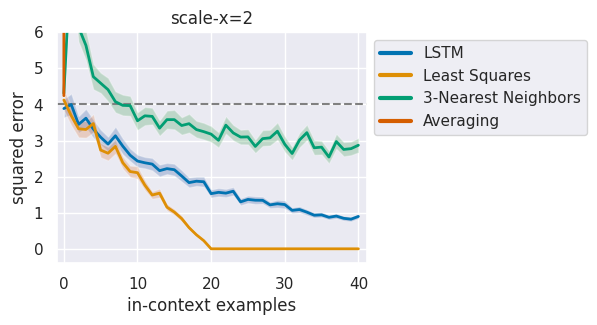

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [9.031658172607422, 9.036116027832032, 8.267650604248047, 8.295777893066406, 7.700574493408203, 7.718729400634766, 6.9852783203125, 6.873829650878906, 6.743772888183594, 6.390574264526367, 6.9701896667480465, 5.699174118041992, 5.876809692382812, 5.75090446472168, 5.412424468994141, 5.428836822509766, 5.6764381408691404, 5.125145339965821, 5.184309005737305, 4.691152572631836, 4.176093673706054, 4.782296752929687, 4.26586685180664, 4.147636413574219, 4.086872100830078, 4.598970413208008, 4.211310958862304, 3.780344009399414, 3.7088932037353515, 3.6133491516113283, 3.6584327697753904, 3.4681591033935546, 3.601399612426758, 3.6712421417236327, 3.460535430908203, 3.5760734558105467, 3.4463485717773437, 3.1203125, 3.20886116027832, 3.122019577026367, 3.0244909286499024], 'std': [13.442236328125, 13.518215942382813, 11.446647644042969, 12.393421173095703, 11.453189086914062, 12.12932

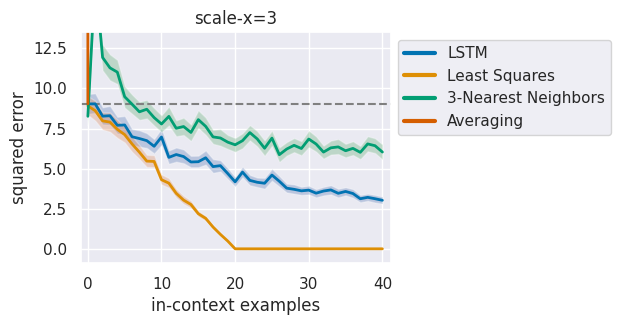

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.11078252792358398, 0.10537140369415283, 0.10302202701568604, 0.0891781508922577, 0.0838362693786621, 0.08586719632148743, 0.08181855082511902, 0.0690879225730896, 0.0759364902973175, 0.06879725456237792, 0.06563512086868287, 0.0665066123008728, 0.06619930267333984, 0.05763598680496216, 0.060699832439422605, 0.05769180059432984, 0.049760866165161136, 0.05031368136405945, 0.044730693101882935, 0.04318833351135254, 0.04277365803718567, 0.0400082528591156, 0.040519118309020996, 0.03896652162075043, 0.03585905730724335, 0.031966200470924376, 0.03319713175296783, 0.03020971417427063, 0.03130788803100586, 0.026480895280838013, 0.027889835834503173, 0.02727007269859314, 0.02566218376159668, 0.024612924456596373, 0.02431919574737549, 0.022828641533851623, 0.021385486423969268, 0.020869262516498566, 0.01976291686296463, 0.019523671269416808, 0.020857593417167662], 'std': [0.16459501981

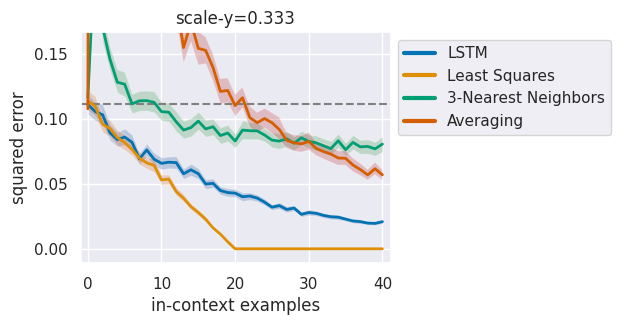

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.2504065275192261, 0.23729248046875, 0.22171380519866943, 0.21494295597076415, 0.19457565546035765, 0.2008807420730591, 0.18655554056167603, 0.16833959817886351, 0.1794173002243042, 0.1639108419418335, 0.16953967809677123, 0.15037889480590821, 0.14387173652648927, 0.13196494579315185, 0.12144567966461181, 0.11055967807769776, 0.11848338842391967, 0.10871365070343017, 0.09509722590446472, 0.09070650935173034, 0.09486041069030762, 0.08344690203666687, 0.07861181497573852, 0.0724075973033905, 0.0722009539604187, 0.06878471374511719, 0.05880619883537293, 0.058505529165267946, 0.06059008836746216, 0.05875356793403626, 0.05601040124893188, 0.058760827779769896, 0.04837109446525574, 0.04754611849784851, 0.04727435111999512, 0.04539565145969391, 0.03901155889034271, 0.043062448501586914, 0.03751626014709473, 0.03816564977169037, 0.03438292443752289], 'std': [0.37085757255554197, 0.353

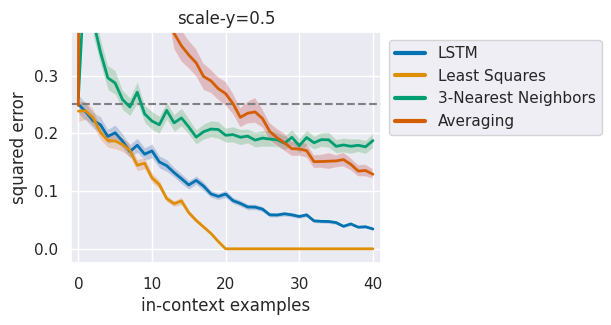

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [4.296708679199218, 3.901304244995117, 3.866640090942383, 3.3403419494628905, 3.270277404785156, 3.181209182739258, 3.0436685562133787, 2.6340185165405274, 2.779286575317383, 2.7043478012084963, 2.4771068572998045, 2.290445327758789, 2.2154619216918947, 2.2875057220458985, 2.1038415908813475, 1.9182315826416017, 1.9182825088500977, 1.6417587280273438, 1.6856201171875, 1.6872840881347657, 1.5448941230773925, 1.5318216323852538, 1.384620189666748, 1.3136709213256836, 1.2490214347839355, 1.2290634155273437, 1.1607333183288575, 1.1038557052612306, 1.1105217933654785, 0.9700310707092286, 0.9223037719726562, 0.8945531845092773, 0.9317808151245117, 0.8665472030639648, 0.854327392578125, 0.8370891571044922, 0.7925837516784668, 0.7725739479064941, 0.7505991458892822, 0.821173095703125, 0.7207278251647949], 'std': [6.042294692993164, 5.650993347167969, 5.894448852539062, 5.138108062744140

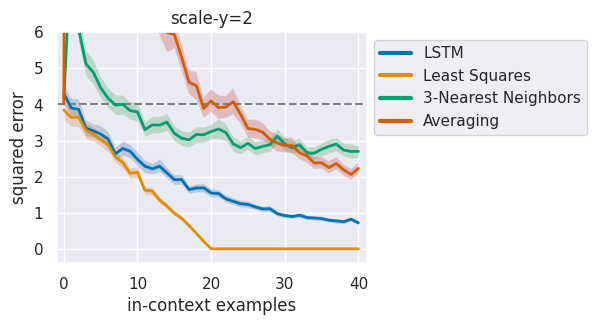

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [8.771976470947266, 8.91728515625, 8.693113708496094, 7.492413330078125, 7.971046447753906, 7.100114440917968, 6.994168853759765, 6.710762023925781, 6.78492431640625, 5.584267425537109, 5.853851318359375, 5.7995342254638675, 5.716799926757813, 5.288646697998047, 5.066707611083984, 4.907179641723633, 4.699080276489258, 4.555686187744141, 4.452330780029297, 4.280809783935547, 4.467115020751953, 4.27301139831543, 4.075968551635742, 4.037863159179688, 3.7595638275146483, 3.811191940307617, 3.507701873779297, 3.3770946502685546, 3.7286956787109373, 3.3212738037109375, 3.4990440368652345, 3.3930458068847655, 3.19832763671875, 3.346532440185547, 3.24157600402832, 3.3281158447265624, 3.064619445800781, 3.01419734954834, 2.9796899795532226, 3.075649070739746, 3.1482147216796874], 'std': [13.02521209716797, 13.136129760742188, 12.760064697265625, 12.482823944091797, 12.60396728515625, 10.

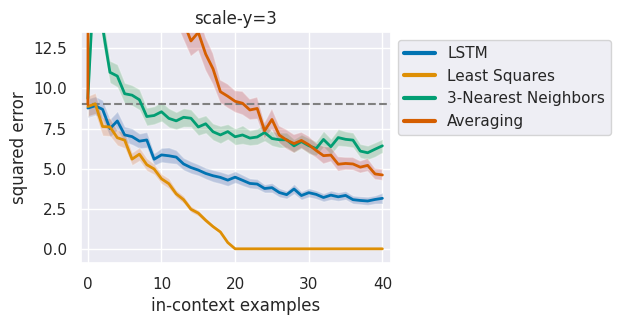

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0132426261901855, 0.70191330909729, 0.5571792125701904, 0.4811999320983887, 0.3851407289505005, 0.33979747295379636, 0.29035172462463377, 0.2960041522979736, 0.22758138179779053, 0.22158989906311036, 0.22007441520690918, 0.1863372802734375, 0.18419710397720337, 0.18053871393203735, 0.1846853971481323, 0.17472692728042602, 0.1590275526046753, 0.15064022541046143, 0.1523693323135376, 0.13869227170944215, 0.14173905849456786, 0.1372532367706299, 0.12213255167007446, 0.12500107288360596, 0.11449017524719238, 0.11660976409912109, 0.10704047679901123, 0.11657077074050903, 0.116726553440094, 0.10775045156478882, 0.10260956287384033, 0.10444059371948242, 0.10113794803619384, 0.10306589603424073, 0.09764575958251953, 0.10310593843460084, 0.09822090864181518, 0.08984346389770508, 0.08957157135009766, 0.09317620396614075, 0.09931006431579589], 'std': [2.1212148666381836, 1.6702697753906

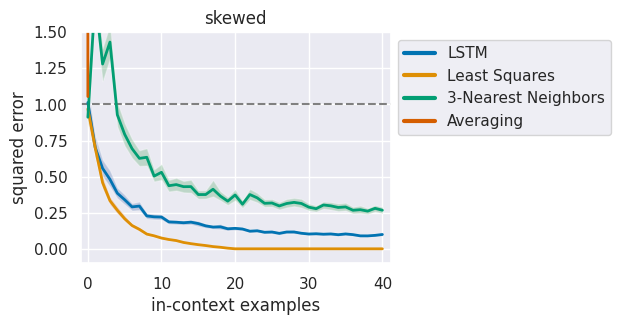

In [56]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [57]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [58]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [ ]:
with torch.no_grad():

    pred = model(xs, ys)

Inside models MLPModel:combine
xs_b.shape: torch.Size([64, 21, 10])
xs_b: tensor([[[-0.3247,  1.2055,  0.7109,  ..., -1.1677,  0.7038, -0.9407],
         [-0.6249, -0.1117,  1.0937,  ...,  0.5388, -0.6047, -0.0910],
         [ 0.1767,  0.3615,  0.3262,  ...,  0.3616, -1.0005,  1.5403],
         ...,
         [-0.1390,  0.2407, -0.3174,  ..., -0.5011, -0.9311,  1.8144],
         [-2.0609, -0.6018, -0.5104,  ..., -1.1032,  2.3624, -1.7188],
         [-0.3284, -0.8960,  0.3571,  ...,  0.3410,  1.9036, -0.3555]],

        [[-0.5275,  0.6228,  1.1700,  ..., -1.1643,  2.4151, -1.5055],
         [-0.4249,  0.2087,  0.4901,  ..., -0.0778, -1.3821, -1.3799],
         [ 0.2435,  1.5733,  0.6799,  ...,  1.7534,  2.8310,  1.4005],
         ...,
         [ 0.8939,  1.9075,  1.1160,  ..., -0.7786, -2.9246, -0.9403],
         [ 0.1574,  0.1338,  0.8965,  ...,  1.1005,  0.0962, -1.0370],
         [ 0.3413, -0.3943, -0.7434,  ...,  0.8545, -0.4930, -0.1031]],

        [[-1.8146,  1.4933,  1.3014,  ...,

In [ ]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

Inside models TransformerModel:_combine
xs_b.shape: torch.Size([64, 101, 20])
xs_b: tensor([[[ 1.0531e+00,  2.4766e+00,  2.3174e+00,  ...,  3.4093e-01,
          -6.0671e+00, -9.1633e-01],
         [-8.4126e-01,  8.4865e-01, -2.8464e+00,  ..., -6.6427e-01,
           2.7870e-01,  2.4132e-01],
         [-7.4701e-01,  9.7212e-01,  1.4168e-01,  ..., -3.1856e+00,
           1.8696e+00, -1.4373e+00],
         ...,
         [ 6.6974e-01,  1.5416e+00, -4.1063e+00,  ..., -1.0358e+00,
          -6.5451e-01, -4.7987e+00],
         [ 1.0321e+00,  1.2024e+00, -6.6848e-01,  ..., -1.7010e-01,
          -2.8807e+00, -2.3439e-01],
         [ 3.1145e-02, -4.4177e-01,  1.0458e+00,  ..., -3.7405e+00,
          -1.0842e+00, -1.5133e+00]],

        [[-1.2935e+00, -1.0665e+00, -1.5721e-01,  ...,  1.1245e+00,
          -2.3525e-01,  2.4130e+00],
         [ 2.1995e+00, -2.1217e+00,  1.8922e+00,  ...,  1.2813e+00,
           7.3086e-01, -1.8028e+00],
         [ 3.7671e+00, -1.0179e+00,  8.7442e-01,  ..., -3.30

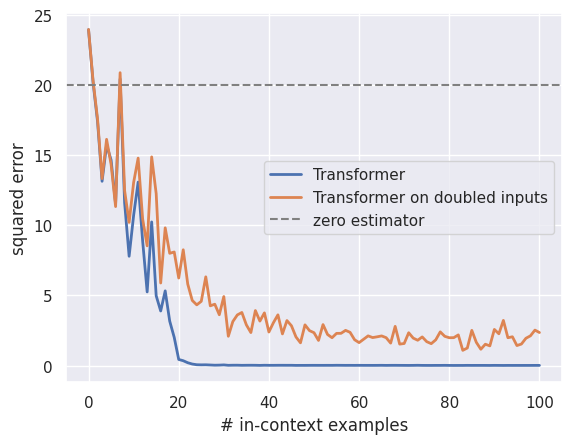

In [ ]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.